## Imports

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score

In [25]:
# Seteamos la seed
import random

random.seed(12121212)
np.random.seed(12121212)

## Actividad 1



En primer lugar, leemos el *dataset* y creamos el *dataframe*:

In [26]:
data = pd.read_csv('data.csv')
data.head()

,Date,Customers,Customers Thousands,Open,Closed,Promo,Store,StateHoliday,SchoolHoliday,DayOfWeek,Sales
0,2015-02-25,616.0,0.616,YES,NO,0.0,340.0,0,NO,3.0,4923.0
1,2014-05-08,476.0,0.476,YES,NO,1.0,1013.0,0,NO,4.0,4562.0
2,2013-02-27,635.0,0.635,YES,NO,0.0,588.0,0,NO,3.0,5293.0
3,2014-04-30,1581.0,1.581,YES,NO,1.0,344.0,0,YES,3.0,12667.0
4,2013-05-13,595.0,0.595,YES,NO,1.0,766.0,0,NO,1.0,7529.0


Lo primero que haremos, será eliminar columnas que presenten información redundante. En particular, las columnas ```Customers Thousands```, ```Closed``` e ```Index``` no tienen ninguna información que podamos considerar valiosa o nueva, ya que la primera tiene la misma información que ```Customers``` (pero ponderada x1000); la segunda tiene la misma información que ```Open``` (pero con el valor de verdad invertido).

La columna ```Store``` **no debe considerarse**, ya que es muy propensa a generar *overfitting*, ya que se trata de un identificador único de cada tienda, pero nosotros queremos generalizar el problema. Evidentemente, habrán tiendas con muy altas ventas, pero no queremos saberlo por su ID, sino que por otras características.

In [27]:
data.drop(['Customers Thousands', 'Closed', 'Store'], axis=1, inplace=True)

Con respecto a la columna ```Date``` se pueden hacer múltiples acercamientos:
* Se puede eliminar, justificando correctamente el motivo, aunque se puede tener una pérdida de información valiosa.

* Lo que haremos nosotros: rescataremos únicamente el mes de la fecha, ya que los días que puedan ser más relevantes ya los tenemos en columnas como ```StateHoliday```, pero hay meses en los que las ventas pueden ser notablemente más altas que en otros:

In [28]:
# Mostramos los tipos de datos antes de los cambios
print('> Tipos de datos antes de los cambios:')
print(data.dtypes, end = '\n' + '-' * 60 + '\n')

# Convertimos 'StateHoliday' a str y 'Date' a datetime y conservamos únicamente el mes:
data['StateHoliday'] = data['StateHoliday'].astype(str)
data['Date'] = pd.to_datetime(data["Date"], format='%Y-%m-%d').dt.month

print('> Tipos de datos después de los cambios:')
print(data.dtypes)

# Mostramos el dataset
display(data)

> Tipos de datos antes de los cambios:
Date              object
Customers        float64
Open              object
Promo            float64
StateHoliday      object
SchoolHoliday     object
DayOfWeek        float64
Sales            float64
dtype: object
------------------------------------------------------------
> Tipos de datos después de los cambios:
Date             float64
Customers        float64
Open              object
Promo            float64
StateHoliday      object
SchoolHoliday     object
DayOfWeek        float64
Sales            float64
dtype: object


,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek,Sales
0,2.0,616.0,YES,0.0,0,NO,3.0,4923.0
1,5.0,476.0,YES,1.0,0,NO,4.0,4562.0
2,2.0,635.0,YES,0.0,0,NO,3.0,5293.0
3,4.0,1581.0,YES,1.0,0,YES,3.0,12667.0
4,5.0,595.0,YES,1.0,0,NO,1.0,7529.0
...,...,...,...,...,...,...,...,...
99995,2.0,888.0,YES,0.0,0,NO,5.0,10100.0
99996,8.0,0.0,NO,0.0,0,YES,7.0,0.0
99997,2.0,818.0,YES,1.0,0,YES,1.0,7920.0
99998,2.0,592.0,YES,1.0,0,NO,4.0,8517.0


Ahora, queremos saber si es que hay registros con valores nulos:

In [29]:
data.isnull().values.any()

True

Para el tratamiento de nulos, dada la poca cantidad de registros con estas características, podemos aceptar como acercamiento válido el simplemente eliminarlos:

In [30]:
data = data.dropna()
display(data)

,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek,Sales
0,2.0,616.0,YES,0.0,0,NO,3.0,4923.0
1,5.0,476.0,YES,1.0,0,NO,4.0,4562.0
2,2.0,635.0,YES,0.0,0,NO,3.0,5293.0
3,4.0,1581.0,YES,1.0,0,YES,3.0,12667.0
4,5.0,595.0,YES,1.0,0,NO,1.0,7529.0
...,...,...,...,...,...,...,...,...
99995,2.0,888.0,YES,0.0,0,NO,5.0,10100.0
99996,8.0,0.0,NO,0.0,0,YES,7.0,0.0
99997,2.0,818.0,YES,1.0,0,YES,1.0,7920.0
99998,2.0,592.0,YES,1.0,0,NO,4.0,8517.0


Para almacenar los datos de mejor manera, cambiaremos las columnas que sabemos que son enteros en vez de *floats* (no es estrictamente necesario):

In [31]:
data['Date'] = data['Date'].astype(int)
data['DayOfWeek'] = data['DayOfWeek'].astype(int)
data['Promo'] = data['Promo'].astype(int)
display(data)

,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek,Sales
0,2,616.0,YES,0,0,NO,3,4923.0
1,5,476.0,YES,1,0,NO,4,4562.0
2,2,635.0,YES,0,0,NO,3,5293.0
3,4,1581.0,YES,1,0,YES,3,12667.0
4,5,595.0,YES,1,0,NO,1,7529.0
...,...,...,...,...,...,...,...,...
99995,2,888.0,YES,0,0,NO,5,10100.0
99996,8,0.0,NO,0,0,YES,7,0.0
99997,2,818.0,YES,1,0,YES,1,7920.0
99998,2,592.0,YES,1,0,NO,4,8517.0


## Actividad 2


La función ```LabelEncoder``` se ocupa para asignar valores numéricos a variables categóricas pertenecientes al arreglo de las *labels*. Su uso **no se recomienda** para categorizar *features* porque es muy propenso a perder la referencia de qué valor está asociado a cada categoría. Sin embargo, con un poco de trabajo se puede hacer. En este caso, no la usaremos en ninguna columna y pasaremos los valores a numéricos "a mano". Para eso partimos por ver los distintos valores que hay en `Promo`:

In [32]:
cat_vars = ['Open', 'StateHoliday', 'SchoolHoliday']

for var in cat_vars:
    print(f'> Variable: {var}')
    print(data[var].unique(), end = '\n' + '-' * 60 + '\n')

> Variable: Open
['YES' 'NO']
------------------------------------------------------------
> Variable: StateHoliday
['0' 'a' 'b' 'c']
------------------------------------------------------------
> Variable: SchoolHoliday
['NO' 'YES']
------------------------------------------------------------


"print('> Tipos de datos por columna')\nprint(data.dtypes, end = '\n' + '-' * 60 + '\n')\n\ndisplay(data)"

Vamos a cambiar los "YES" por 1's y los "NO" por 0's. En el caso de `StateHoliday` reemplazaremos en orden por 0, 1, 2 y 3:

In [40]:
# Ponemos valores numéricos a Open y lo cambiamos a tipo int
data.loc[data['Open'] == 'NO', 'Open'] = 0
data.loc[data['Open'] == 'YES', 'Open'] = 1
data['Open'] = data['Open'].astype(int)

# Ponemos valores numéricos a Open y lo cambiamos a tipo int
data.loc[data['StateHoliday'] == '0', 'StateHoliday'] = 0
data.loc[data['StateHoliday'] == 'a', 'StateHoliday'] = 1
data.loc[data['StateHoliday'] == 'b', 'StateHoliday'] = 2
data.loc[data['StateHoliday'] == 'c', 'StateHoliday'] = 3
data['StateHoliday'] = data['StateHoliday'].astype(int)

# Ponemos valores numéricos a Open y lo cambiamos a tipo int
data.loc[data['SchoolHoliday'] == 'NO', 'SchoolHoliday'] = 0
data.loc[data['SchoolHoliday'] == 'YES', 'SchoolHoliday'] = 1
data['SchoolHoliday'] = data['SchoolHoliday'].astype(int)

display(data)

,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek,Sales
0,2,616.0,1,0,0,0,3,4923.0
1,5,476.0,1,1,0,0,4,4562.0
2,2,635.0,1,0,0,0,3,5293.0
3,4,1581.0,1,1,0,1,3,12667.0
4,5,595.0,1,1,0,0,1,7529.0
...,...,...,...,...,...,...,...,...
99995,2,888.0,1,0,0,0,5,10100.0
99996,8,0.0,0,0,0,1,7,0.0
99997,2,818.0,1,1,0,1,1,7920.0
99998,2,592.0,1,1,0,0,4,8517.0


## Actividad 3


Para esta pregunta hay muchos acercamientos posibles. El más probable es que dividan los datos de forma equitativa para cada categoría (por quintiles), lo cual está bien, aunque podrían presentar complicaciones en el rendimiento. En esta pauta, se propone un modelo usual para dividir ventas entre sus valores extremos y los estándar. Para esto, el primero 10% de los datos será el de ventas muy bajas, mientras que el último 10% será el de las ventas muy altas. Existe la opción de seguir distribuciones Gamma también.

El de ventas bajas serán los datos entre el 10% y 30%, mientras que el de ventas altas estará entre el 70% y 90% de los datos. Mientras que las ventas medias/normales, son aquellas que se mueven entre el 30% y 70% de los datos (la categoría más amplia). La lógica detrás de esta división es que los valores extremos son menos usuales, mientras que se van duplicando a medida que se acercan a valores más centrales.

Si graficamos las ventas continuas, tenemos lo siguiente (no es estrictamente necesario):

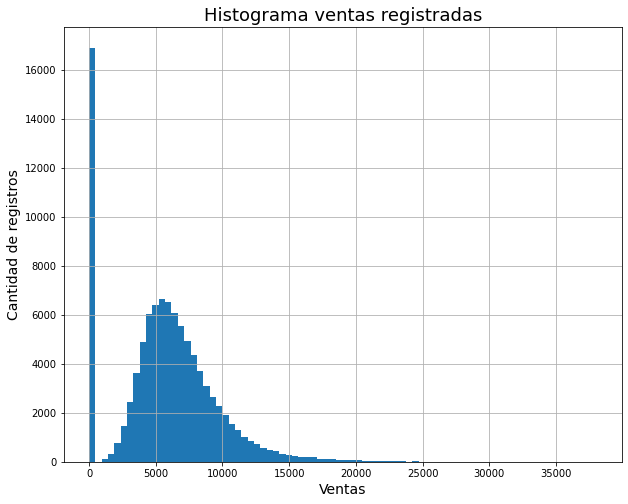

In [41]:
data['Sales'].hist(bins=80, figsize=(10,8))
plt.title('Histograma ventas registradas', fontsize = 18)
plt.xlabel('Ventas', fontsize = 14)
plt.ylabel('Cantidad de registros', fontsize = 14)
plt.show()

Ahora, calculamos los deciles para poder hacer la división:

In [42]:
deciles = np.percentile(data['Sales'], np.arange(0, 100, 10))
print(deciles)

[    0.      0.   2956.   4229.   5014.   5731.   6479.8  7337.   8451.
 10281. ]


Creamos una nueva columna llamada ```Sales Category```, donde se asigna la categoría según el nivel de ventas:
* muy bajas: 0
* bajas:     1
* normales:  2
* altas:     3
* muy altas: 4

In [43]:
# Sumamos y restamos 100 porque no pueden haber intervalos donde el límite inferior y superior sea igual
data['Sales Category'] = pd.cut(data['Sales'], bins=[deciles[0] - 10, deciles[1] + 10, 
                                                     deciles[3], deciles[8], 
                                                     deciles[9], data['Sales'].max()], 
                                labels=[0, 1, 2, 3, 4])

display(data)

,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek,Sales,Sales Category
0,2,616.0,1,0,0,0,3,4923.0,2
1,5,476.0,1,1,0,0,4,4562.0,2
2,2,635.0,1,0,0,0,3,5293.0,2
3,4,1581.0,1,1,0,1,3,12667.0,4
4,5,595.0,1,1,0,0,1,7529.0,2
...,...,...,...,...,...,...,...,...,...
99995,2,888.0,1,0,0,0,5,10100.0,3
99996,8,0.0,0,0,0,1,7,0.0,0
99997,2,818.0,1,1,0,1,1,7920.0,2
99998,2,592.0,1,1,0,0,4,8517.0,3


Ahora, para evitar "hacer trampa" eliminamos la columna ```Sales```:

In [44]:
data.drop(['Sales'], axis=1, inplace=True)
display(data)

,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek,Sales Category
0,2,616.0,1,0,0,0,3,2
1,5,476.0,1,1,0,0,4,2
2,2,635.0,1,0,0,0,3,2
3,4,1581.0,1,1,0,1,3,4
4,5,595.0,1,1,0,0,1,2
...,...,...,...,...,...,...,...,...
99995,2,888.0,1,0,0,0,5,3
99996,8,0.0,0,0,0,1,7,0
99997,2,818.0,1,1,0,1,1,2
99998,2,592.0,1,1,0,0,4,3


Mostramos un histograma con la cantidad de instancias por categoría:

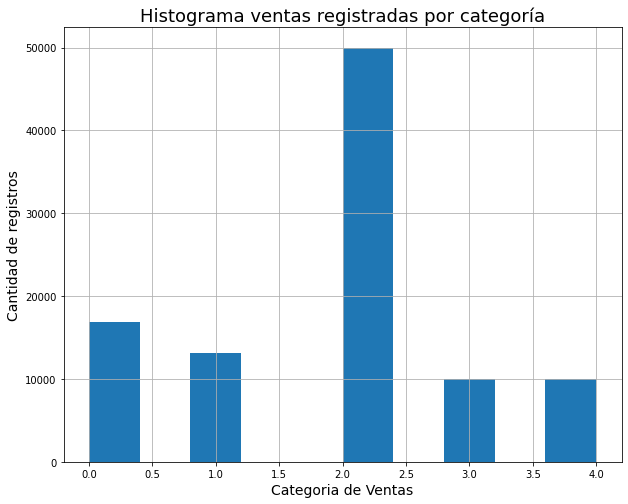

In [45]:
data['Sales Category'].hist(figsize=(10,8))
plt.title('Histograma ventas registradas por categoría', fontsize = 18)
plt.xlabel('Categoria de Ventas', fontsize = 14)
plt.ylabel('Cantidad de registros', fontsize = 14)
plt.show()

Esta distribución de ventas es útil para estos propósitos, aunque lo esperable es que opten por una distribución balanceada (quintiles).

## Actividad 4


Ordenamos el *dataset* por nivel de ventas:

In [46]:
data = data.sort_values('Sales Category')
display(data)

,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek,Sales Category
67488,5,0.0,0,0,0,0,7,0
41193,6,0.0,0,0,0,0,7,0
75667,4,0.0,0,0,0,0,7,0
87977,8,0.0,0,0,0,0,7,0
63923,4,0.0,0,0,0,0,7,0
...,...,...,...,...,...,...,...,...
84982,1,851.0,1,1,0,0,1,4
61875,11,944.0,1,1,0,0,1,4
61872,7,717.0,1,1,0,0,3,4
17170,5,1684.0,1,0,0,0,5,4


Usamos el primer 70% para train y el otro 30% para test:

In [47]:
bad_train = data[:int(data.shape[0] * 0.7)].copy()
bad_test = data[int(data.shape[0] * 0.7):].copy()

print("> Train:")
display(bad_train)

print("> Test:")
display(bad_test)

> Train:


,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek,Sales Category
67488,5,0.0,0,0,0,0,7,0
41193,6,0.0,0,0,0,0,7,0
75667,4,0.0,0,0,0,0,7,0
87977,8,0.0,0,0,0,0,7,0
63923,4,0.0,0,0,0,0,7,0
...,...,...,...,...,...,...,...,...
10874,5,656.0,1,1,0,0,2,2
10875,12,421.0,1,0,0,0,1,2
10852,3,749.0,1,0,0,0,3,2
11232,11,534.0,1,1,0,0,3,2


> Test:


,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek,Sales Category
11234,8,666.0,1,1,0,1,4,2
11547,5,630.0,1,0,0,0,6,2
11548,4,533.0,1,1,0,0,2,2
11553,6,1012.0,1,1,0,0,3,2
11554,5,853.0,1,0,0,0,4,2
...,...,...,...,...,...,...,...,...
84982,1,851.0,1,1,0,0,1,4
61875,11,944.0,1,1,0,0,1,4
61872,7,717.0,1,1,0,0,3,4
17170,5,1684.0,1,0,0,0,5,4


Definimos una lista con las features y el target:

In [48]:
features = ['Date', 'Customers', 'Open', 'Promo', 'StateHoliday', 'DayOfWeek']
target = 'Sales Category'

Creamos matrices X y vectores y para train y test

In [49]:
X_bad_train, y_bad_train = bad_train[features], bad_train[target]
X_bad_test, y_bad_test = bad_test[features], bad_test[target]

```criterion``` corresponde a la métrica usada para priorizar y elegir ciertos atributos por sobre otros, es decir es la métrica que define la construcción del árbol (como la entropía). ```max_depth``` corresponde a la profundidad máxima que puede tener el árbol (en términos de "capas"). ```n_estimators``` es la cantidad de árboles van a componer el RandomForest.

Hacemos el estudio de hiperparámetros con distintos valores de ```criterion```, ```max_depth``` y ```n_estimators``` utilizando ```cross_val_score```. Esta función recibe el *dataset* que se le entrega y hace ```cv``` divisiones de este set, generando distintos sets de validación y calculando la métrica establecida (en este caso *accuracy*). De esta forma, el set de validación está implícito en la función:

In [50]:
best_acc_forest = 0
print("%12s %12s %12s %12s" % ("criterion", "max_depth", "n", "accuracy"))

for crit in ["gini", "entropy"]:
    for d in [5, 10, 20, 30]:
        for n in [50, 75, 100]:

            forest_model = RandomForestClassifier(criterion=crit, max_depth=d, n_estimators=n)
            acc = cross_val_score(forest_model, X_bad_train, y_bad_train, cv = 5, scoring='accuracy').mean()

            if acc > best_acc_forest:
                best_acc_forest = acc
                best_forest = forest_model

            print("%12.7s %12.1f %12.1f %12.4f" % (crit, d, n, acc))

print()
print(f"mejor modelo: {best_forest}")
print(f"accuracy mejor modelo: {best_acc_forest}")

   criterion    max_depth            n     accuracy
        gini          5.0         50.0       0.8959
        gini          5.0         75.0       0.8966
        gini          5.0        100.0       0.8963
        gini         10.0         50.0       0.8977
        gini         10.0         75.0       0.8980
        gini         10.0        100.0       0.8983
        gini         20.0         50.0       0.8743
        gini         20.0         75.0       0.8748
        gini         20.0        100.0       0.8747
        gini         30.0         50.0       0.8708
        gini         30.0         75.0       0.8720
        gini         30.0        100.0       0.8715
     entropy          5.0         50.0       0.8940
     entropy          5.0         75.0       0.8918
     entropy          5.0        100.0       0.8941
     entropy         10.0         50.0       0.8980
     entropy         10.0         75.0       0.8981
     entropy         10.0        100.0       0.8984
     entropy

Entrenamos nuevamente el mejor clasificador encontrado en la celda anterior:

In [20]:
best_forest.fit(X_bad_train, y_bad_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=75)

Probamos nuestro clasificador en el set de train

In [21]:
y_pred = best_forest.predict(X_bad_train)
acc = accuracy_score(y_bad_train, y_pred)
print(f'> Accuracy en train: {round(acc, 4)}')

> Accuracy en train: 0.9022


Ahora, probamos el clasificador en el set de test:

In [22]:
y_pred = best_forest.predict(X_bad_test)
acc = accuracy_score(y_bad_test, y_pred)
print(f'> Accuracy en test: {round(acc, 4)}')

> Accuracy en test: 0.3136


Creamos una nueva matriz X y vector y de manera de tener solo las ventas muy altas (hay muchas maneras):

In [23]:
X_test_high = X_bad_test.loc[y_bad_test.loc[y_bad_test == 4].index][features]
y_test_high = y_bad_test.loc[y_bad_test == 4]

Probamos nuestro clasificador en el set solo con instancias de la categoría "Very High Sales"

In [24]:
y_pred = best_forest.predict(X_test_high)
acc = accuracy_score(y_test_high, y_pred)
print(f'> Accuracy en test (ventas muy altas): {round(acc, 4)}')

> Accuracy en test (ventas muy altas): 0.0


Claramente, el rendimiento en el set de train es notablemente superior y en test es muy bajo, especialmente cuando solo trabajamos con ventas muy altas. Esto se debe a que, al haber ordenado el *dataset* por ventas (categóricamente) y ocupar el primer 70% para train, hay categorías como la correspondiente a ventas muy altas (4) que no fueron usadas para el entrenamiento y, por ende, no sabe que esa categoría existe.

## Actividad 5


Separación de los datos en 70% train y 30% test usando ```train_test_split``` de SKlearn. Esta función se encarga de mantener la proporción de categorías balanceada entre train y test:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.30)

Cantidad de instancias de cada clase en set de train

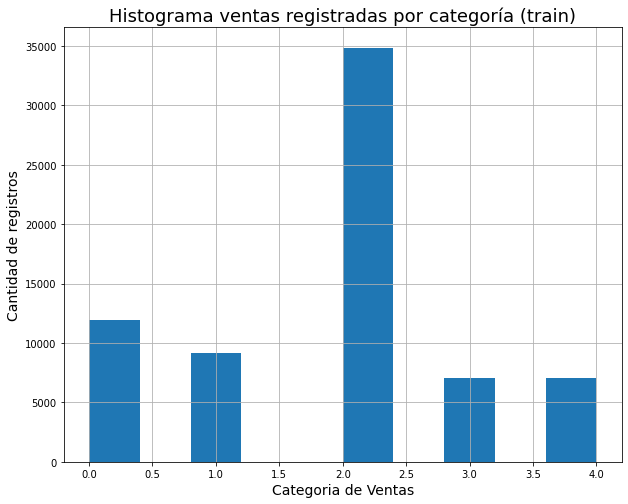

In [26]:
data.loc[y_train.index]['Sales Category'].hist(figsize=(10,8))
plt.title('Histograma ventas registradas por categoría (train)', fontsize = 18)
plt.xlabel('Categoria de Ventas', fontsize = 14)
plt.ylabel('Cantidad de registros', fontsize = 14)
plt.show()

Lo mismo para el set de test:

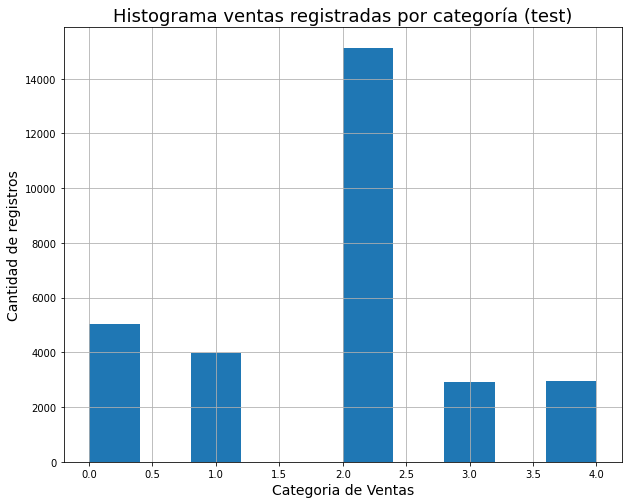

In [27]:
data.loc[y_test.index]['Sales Category'].hist(figsize=(10,8))
plt.title('Histograma ventas registradas por categoría (test)', fontsize = 18)
plt.xlabel('Categoria de Ventas', fontsize = 14)
plt.ylabel('Cantidad de registros', fontsize = 14)
plt.show()

Vemos que las proporciones se mantienen con respecto al set original y entre train y set. Ahora, buscamos hiper-parámetros para entrenar un buen modelo:

In [28]:
best_acc_forest = 0
print("%12s %12s %12s %12s" % ("criterion", "max_depth", "n", "accuracy"))

for crit in ["gini", "entropy"]:
    for d in [5, 10, 20, 30]:
        for n in [50, 75, 100]:

            forest_model = RandomForestClassifier(criterion=crit, max_depth=d, n_estimators=n)
            acc = cross_val_score(forest_model, X_train, y_train, cv = 5, scoring='accuracy').mean()

            if acc > best_acc_forest:
                best_acc_forest = acc
                best_forest = forest_model

            print("%12.7s %12.1f %12.1f %12.4f" % (crit, d, n, acc))

print()
print(f"mejor modelo: {best_forest}")
print(f"accuracy mejor modelo: {best_acc_forest}")

   criterion    max_depth            n     accuracy
        gini          5.0         50.0       0.7709
        gini          5.0         75.0       0.7715
        gini          5.0        100.0       0.7727
        gini         10.0         50.0       0.7876
        gini         10.0         75.0       0.7883
        gini         10.0        100.0       0.7876
        gini         20.0         50.0       0.7504
        gini         20.0         75.0       0.7509
        gini         20.0        100.0       0.7513
        gini         30.0         50.0       0.7292
        gini         30.0         75.0       0.7298
        gini         30.0        100.0       0.7306
     entropy          5.0         50.0       0.7589
     entropy          5.0         75.0       0.7607
     entropy          5.0        100.0       0.7573
     entropy         10.0         50.0       0.7872
     entropy         10.0         75.0       0.7876
     entropy         10.0        100.0       0.7872
     entropy

Entrenamos el modelo encontrado en el set de train:

In [29]:
best_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=75)

Probamos nuestro clasificador en el set de train

In [30]:
y_pred = best_forest.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print(f'> Accuracy en train: {round(acc, 4)}')

> Accuracy en train: 0.7973


Probamos nuestro clasificador en el set de test

In [31]:
y_pred = best_forest.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'> Accuracy en test: {round(acc, 4)}')

> Accuracy en test: 0.7959


Probamos nuestro clasificador en el set solo con instancias de la categoría de ventas muy altas (4), para eso las filtramos nuevamente:

In [32]:
X_test_high = X_test.loc[y_test.loc[y_test == 4].index][features]
y_test_high = y_test.loc[y_test == 4]

Probamos el rendimiento:

In [33]:
y_pred = best_forest.predict(X_test_high)
acc = accuracy_score(y_test_high, y_pred)
print(f'> Accuracy en test (ventas muy altas): {round(acc, 4)}')

> Accuracy en test (ventas muy altas): 0.6976


Vemos que el rendimiento es mucho más constante que en la primera parte y que el modelo mantiene relativamente bien su rendimiento con la categoría de ventas muy altas, ya que en el entrenamiento también recibió instancias correspondientes a esta categoría.

## Actividad 6


Creamos nuestra matriz de confusión

C:\Users\ferna\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


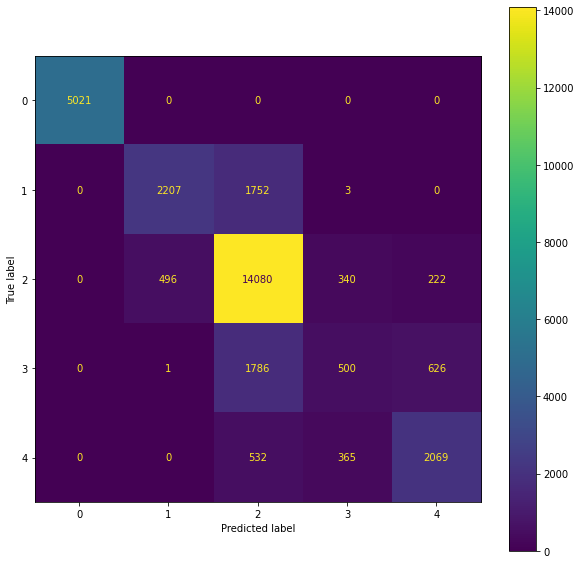

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(best_forest, X_test, y_test, ax=ax, values_format=".0f", labels=[0, 1, 2, 3, 4])
plt.show()

La categoría que más se confunden entre sí son High Sales y Medium Sales. Podemos ver que 1276 instancias de High Sales fueron erroneamente clasificadas como Medium Sales, y 977 instancias de Medium Sales fueron erroneamente clasificadas como High Sales. Esto es normal, puesto que lo esperable es que las categorías menos extremistas (i.e. intermedias) tengan una división más difusa en sus límites.

## Actividad 7

La precisión mide la proporción de instancias clasificadas correctamente como "X" sobre el total de instancias correspondientes a la categoría "X". En nuestro contexto, si, por ejemplo, quisieramos medir la precisión, es equivalente a decir "si decimos que algo es de una categoría, cuántas veces acertamos"

Por otro lado *recall* mide la proporción de instancias clasificadas correctamente en una categoría sobre ese valor más los falsos-negativos. De este modo, el *recall* es equivalente a decir "de las instancias que pertenecen a una categoría, cuántas estoy detectando"

Un ejemplo donde sería conveniente priorizar precisión, podría ser si quisieramos construir un recomendador de videos, queremos asegurarnos de que casi todos los videos recomendados sean relevantes para el usuario, por lo que queremos una precisión alta.

Un ejemplo donde sería conveniente priorizar *recall*, podría ser si queremos detectar problemas al corazón en pacientes. En este caso, queremos asegurarnos de que el clasificador tenga un alto *recall*, de modo que se detecten correctamente la mayor cantidad posible de pacientes con problemas al corazón, a pesar de que podamos decir a algunas personas sanas que estén enfermas.


Precisión de nuestro modelo

In [35]:
y_pred = best_forest.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
precision

0.743030690438616

*Recall* de nuestro modelo

In [36]:
recall = recall_score(y_test, y_pred, average='macro')
recall

0.6712736793892906

## Actividad 8

No tiene sentido usar una regresión lineal porque no estamos intentando predecir valores continuos, sino que solamente queremos clasificar la categoría correspondiente al nivel de ventas en base a características de una instancia determinada.